# MiDaSv3 Depth Estimation of Landmark Features

> [Getting Started with Depth Estimation using MiDaS](https://medium.com/artificialis/getting-started-with-depth-estimation-using-midas-and-python-d0119bfe1159): Monocular depth estimation using [MiDaSv3](https://github.com/isl-org/MiDaS) and the [MediaPipe Body Pose Estimator](https://github.com/google/mediapipe/blob/master/docs/solutions/pose.md).
>
> By [Nabeel Khan](https://medium.com/@nbeel.original) @[Artificialis](https://medium.com/artificialis)

In [5]:
import cv2 as cv
from glob import glob
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np
from scipy.interpolate import RectBivariateSpline
import torch

## Setup

In [39]:
test_images = glob('assets/*.jpg')
test_images

['assets/cyber_02.jpg',
 'assets/cyber_06.jpg',
 'assets/cyber_08.jpg',
 'assets/cyber_10.jpg',
 'assets/cyber_11.jpg',
 'assets/cyber_12.jpg']

In [97]:
image = plt.imread(test_images[5])

In [ ]:
# downloading the Midas model from TorchHub.
#model_type = "DPT_Large"     # MiDaS v3 - Large (1.28GM) (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid (470M) (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small (82M) (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type, trust_repo=True)

# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

In [ ]:
# initialize the mediapipe pose estimator
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False)

In [10]:
# Use transforms to resize and normalize the image
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /home/xiaodie/.cache/torch/hub/intel-isl_MiDaS_master


In [11]:
# converting depth to distance
def depth_to_distance(depth_value,depth_scale):
  return -1.0/(depth_value*depth_scale)

## Pose Estimation

In [ ]:
# Detect the body landmarks in the frame
results = pose.process(image)
results.pose_landmarks

In [99]:
# Draw Landmarks
mp_drawing = mp.solutions.drawing_utils
mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

(-0.5, 735.5, 612.5, -0.5)

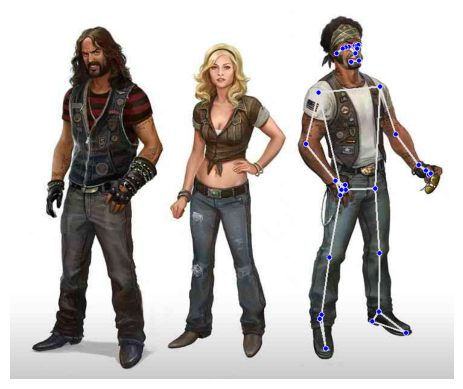

In [100]:
plt.imshow(image, cmap=plt.cm.binary)
plt.axis(False)

In [101]:
# extract landmark coordinates
landmarks = []

for landmark in results.pose_landmarks.landmark:
    landmarks.append((landmark.x, landmark.y, landmark.z))

# extract left and right waist landmarks
waist_landmarks = [results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP],
                   results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]]
# finding midpoint from waist    
mid_point = ((waist_landmarks[0].x + waist_landmarks[1].x) / 2, (waist_landmarks[0].y + waist_landmarks[1].y) / 2)
mid_x , mid_y = mid_point

## Create Depth Map

In [102]:
imgbatch = transform(image).to(device)

# Making a prediction
with torch.no_grad():
    prediction = midas(imgbatch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=image.shape[:2],
        mode='bicubic',
        align_corners=False
    ).squeeze()

output = prediction.cpu().numpy()

# normalizing the output predictions for cv2 to read.
output_norm = cv.normalize(output, None, 0, 1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

# colored depth map
output_norm_c = (output_norm*255).astype(np.uint8)
output_norm_c = cv.applyColorMap(output_norm_c, cv.COLORMAP_MAGMA)

(-0.5, 735.5, 612.5, -0.5)

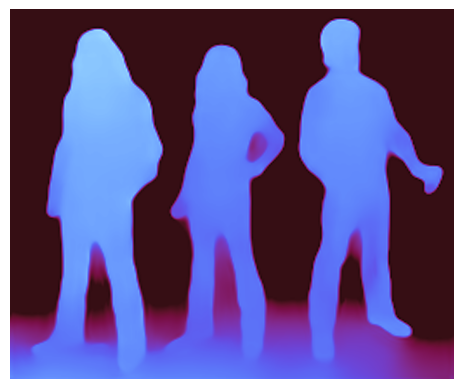

In [103]:
plt.imshow(output_norm_c, cmap=plt.cm.binary)
plt.axis(False)

(-0.5, 462.5, 388.5, -0.5)

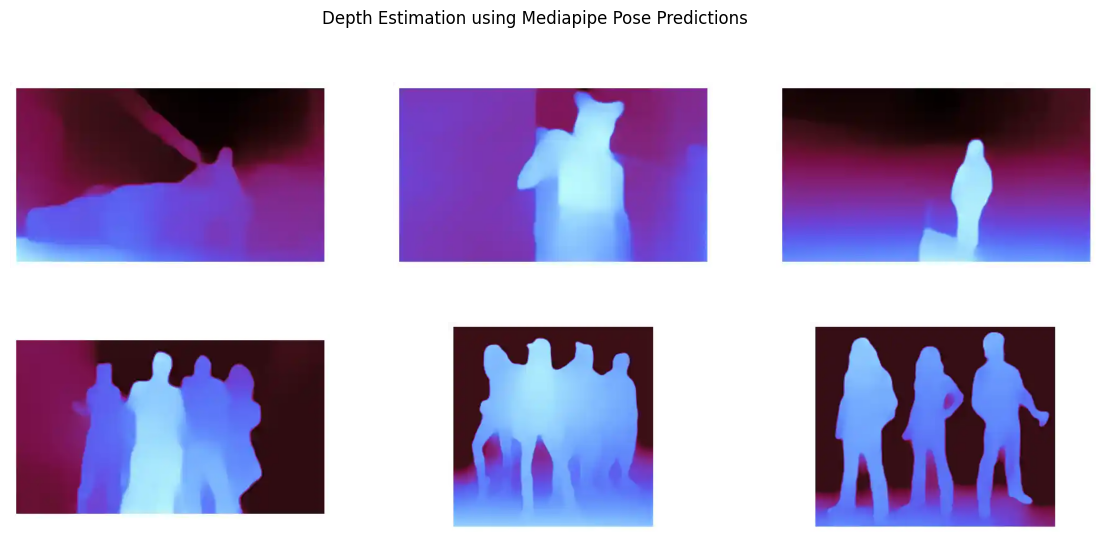

In [110]:
plt.figure(figsize=(14, 6))
plt.suptitle('Depth Estimation using Mediapipe Pose Predictions')

ax = plt.subplot(2, 3, 1)
plt.imshow(plt.imread('assets/depth_01.webp'))
plt.axis(False)

ax = plt.subplot(2, 3, 2)
plt.imshow(plt.imread('assets/depth_02.webp'))
plt.axis(False)

ax = plt.subplot(2, 3, 3)
plt.imshow(plt.imread('assets/depth_03.webp'))
plt.axis(False)

ax = plt.subplot(2, 3, 4)
plt.imshow(plt.imread('assets/depth_04.webp'))
plt.axis(False)

ax = plt.subplot(2, 3, 5)
plt.imshow(plt.imread('assets/depth_05.webp'))
plt.axis(False)

ax = plt.subplot(2, 3, 6)
plt.imshow(plt.imread('assets/depth_06.webp'))
plt.axis(False)

## Get Depth of Selected Point

In [104]:
# creating a spline array of non-integer grid
h , w = output_norm.shape
x_grid = np.arange(w)
y_grid = np.arange(h)

# create a spline object using the output_norm array
spline = RectBivariateSpline(y_grid, x_grid, output_norm)

In [105]:
#Passing the x and y co-ordinates distance function to calculate distance.
#Tweak with the depth scale to see what suits you!
depth_scale = 1
depth_mid_filt = spline(mid_y,mid_x)
depth_midas = depth_to_distance(depth_mid_filt, depth_scale)

(-0.5, 735.5, 612.5, -0.5)

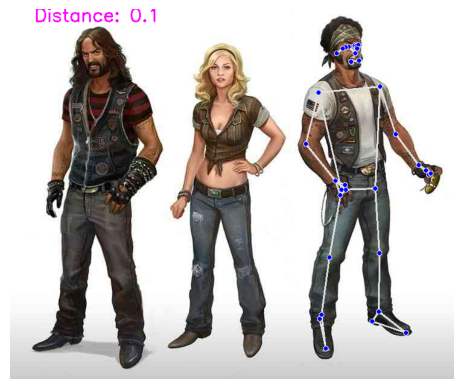

In [106]:
cv.putText(image, 'Distance: ' + str(np.format_float_positional(depth_mid_filt, precision=2)),(40,20),cv.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2)

plt.imshow(image, cmap=plt.cm.binary)
plt.axis(False)

(-0.5, 462.5, 388.5, -0.5)

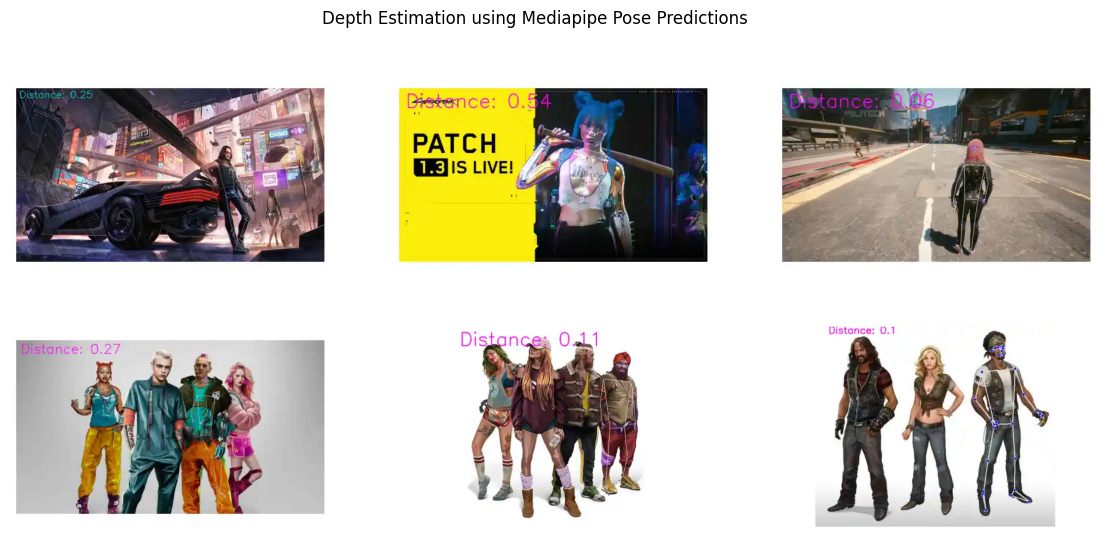

In [108]:
plt.figure(figsize=(14, 6))
plt.suptitle('Depth Estimation using Mediapipe Pose Predictions')

ax = plt.subplot(2, 3, 1)
plt.imshow(plt.imread('assets/pose_midas_1.webp'))
plt.axis(False)

ax = plt.subplot(2, 3, 2)
plt.imshow(plt.imread('assets/pose_midas_2.webp'))
plt.axis(False)

ax = plt.subplot(2, 3, 3)
plt.imshow(plt.imread('assets/pose_midas_3.webp'))
plt.axis(False)

ax = plt.subplot(2, 3, 4)
plt.imshow(plt.imread('assets/pose_midas_4.webp'))
plt.axis(False)

ax = plt.subplot(2, 3, 5)
plt.imshow(plt.imread('assets/pose_midas_5.webp'))
plt.axis(False)

ax = plt.subplot(2, 3, 6)
plt.imshow(plt.imread('assets/pose_midas_6.webp'))
plt.axis(False)